# Test permute_to_identity_hungarian Performance

In [3]:
import time
import torch
from spd.utils.target_ci_solutions import permute_to_identity_hungarian

In [18]:
import signal
from datetime import datetime

class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException()

# Test square matrices at different sizes and densities
sizes = [25, 50, 100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
timeout_seconds = 150

# Define test scenarios with two types:
# Type 1: Percentage-based density
# Type 2: Constant average nnz per row
scenarios = [
    ("Fully Dense", "percent", 1.0),
]

# Store results locally
results = []

print("Size\tScenario\t\tActual nnz/row\tTime (s)\tStatus")
print("="*75)

for size in sizes:
    for scenario_name, density_type, value in scenarios:
        
        # Skip if constant nnz exceeds matrix size
        if density_type == "constant_nnz" and value > size:
            continue
        
        # Create random matrix with values between 0 and 1
        ci_array = torch.rand(size, size)
        
        # Apply mask based on density type
        if density_type == "percent":
            # Percentage-based density
            if value < 1.0:
                mask = torch.rand(size, size) < value
                ci_array = ci_array * mask.float()
        else:  # constant_nnz
            # Constant number of non-zeros per row (on average)
            # Convert to percentage for this matrix size
            target_density = value / size
            mask = torch.rand(size, size) < target_density
            ci_array = ci_array * mask.float()
        
        # Calculate actual density
        actual_nnz_total = (ci_array != 0).sum().item()
        actual_density = actual_nnz_total / (size * size) * 100
        actual_avg_nnz = actual_nnz_total / size
        
        # Set up timeout
        signal.signal(signal.SIGALRM, timeout_handler)
        signal.alarm(timeout_seconds)
        
        try:
            start = time.time()
            permuted_ci, perm_indices = permute_to_identity_hungarian(ci_array)
            elapsed = time.time() - start
            signal.alarm(0)  # Cancel the alarm
            
            status = "" if size != 1000 else ("✓ PASS" if elapsed < 1.0 else "✗ FAIL")
            
            results.append({
                'size': size,
                'scenario': scenario_name,
                'density_type': density_type,
                'target_value': value,
                'avg_nnz_per_row': actual_avg_nnz,
                'density': actual_density,
                'time': elapsed,
                'completed': True
            })
            
            print(f"{size}\t{scenario_name:<16}\t{actual_avg_nnz:.1f}\t\t{elapsed:.4f}\t{status}")
            
        except TimeoutException:
            signal.alarm(0)  # Cancel the alarm
            
            results.append({
                'size': size,
                'scenario': scenario_name,
                'density_type': density_type,
                'target_value': value,
                'avg_nnz_per_row': actual_avg_nnz,
                'density': actual_density,
                'time': None,
                'completed': False
            })
            
            # Informative timeout message
            print(f"{size}\t{scenario_name:<16}\t{actual_avg_nnz:.1f}\t\tTIMEOUT\t✗ TIMEOUT after {timeout_seconds}s")
            print(f"  → Matrix density: {actual_density:.2f}% ({actual_nnz_total:,} total non-zeros)")
            
            # Estimate based on previous successful runs
            prev = [r for r in results if r['completed'] and r['scenario'] == scenario_name]
            if prev:
                last = prev[-1]
                estimated = last['time'] * (size/last['size'])**3
                print(f"  → Estimated time: ~{estimated:.1f}s based on {last['size']}x{last['size']} result")

# Summary
completed = sum(1 for r in results if r['completed'])
timeouts = sum(1 for r in results if not r['completed'])
print(f"\nSummary: {completed} completed, {timeouts} timeouts")

# Analysis by density type
print("\n" + "="*60)
print("PERCENTAGE-BASED DENSITY RESULTS:")
print("="*60)
percent_scenarios = [s for s in scenarios if s[1] == "percent"]
for scenario_name, _, target in percent_scenarios:
    scenario_results = [r for r in results if r['scenario'] == scenario_name]
    if scenario_results:
        print(f"\n{scenario_name} (target: {target*100:.1f}%):")
        for r in scenario_results:
            if r['completed']:
                print(f"  {r['size']}x{r['size']}: {r['time']:.4f}s (actual: {r['density']:.2f}%, {r['avg_nnz_per_row']:.1f} nnz/row)")
            else:
                print(f"  {r['size']}x{r['size']}: TIMEOUT (actual: {r['density']:.2f}%, {r['avg_nnz_per_row']:.1f} nnz/row)")

print("\n" + "="*60)
print("CONSTANT NNZ/ROW RESULTS:")
print("="*60)
const_scenarios = [s for s in scenarios if s[1] == "constant_nnz"]
for scenario_name, _, target in const_scenarios:
    scenario_results = [r for r in results if r['scenario'] == scenario_name]
    if scenario_results:
        print(f"\n{scenario_name} (target: {target} nnz/row):")
        for r in scenario_results:
            if r['completed']:
                print(f"  {r['size']}x{r['size']}: {r['time']:.4f}s (actual: {r['avg_nnz_per_row']:.1f} nnz/row, {r['density']:.2f}%)")
            else:
                print(f"  {r['size']}x{r['size']}: TIMEOUT (actual: {r['avg_nnz_per_row']:.1f} nnz/row, {r['density']:.2f}%)")

Size	Scenario		Actual nnz/row	Time (s)	Status
25	Fully Dense     	25.0		0.0021	
50	Fully Dense     	50.0		0.0034	
100	Fully Dense     	100.0		0.0134	
250	Fully Dense     	250.0		0.1549	
500	Fully Dense     	500.0		1.5058	
750	Fully Dense     	750.0		7.6459	
1000	Fully Dense     	1000.0		25.8876	✗ FAIL
1250	Fully Dense     	1250.0		54.3529	
1500	Fully Dense     	1500.0		103.4925	
1750	Fully Dense     	1750.0		TIMEOUT	✗ TIMEOUT after 150s
  → Matrix density: 100.00% (3,062,500 total non-zeros)
  → Estimated time: ~164.3s based on 1500x1500 result
2000	Fully Dense     	2000.0		TIMEOUT	✗ TIMEOUT after 150s
  → Matrix density: 100.00% (3,999,999 total non-zeros)
  → Estimated time: ~245.3s based on 1500x1500 result

Summary: 9 completed, 2 timeouts

PERCENTAGE-BASED DENSITY RESULTS:

Fully Dense (target: 100.0%):
  25x25: 0.0021s (actual: 100.00%, 25.0 nnz/row)
  50x50: 0.0034s (actual: 100.00%, 50.0 nnz/row)
  100x100: 0.0134s (actual: 100.00%, 100.0 nnz/row)
  250x250: 0.1549s (actual: 10

In [28]:
np.sum(sizes_cubed**2)

np.int64(-2047573135965410991)

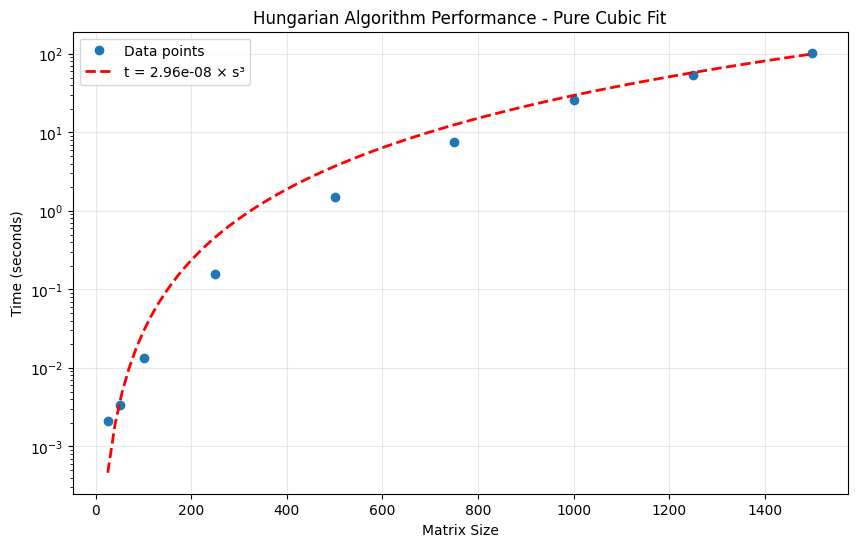

Pure cubic fit: t = 2.96e-08 × s³


In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Collect all completed results
all_sizes = []
all_times = []
for r in results:
   if r['completed']:
       all_sizes.append(r['size'])
       all_times.append(r['time'])

# Convert to arrays
sizes = np.array(all_sizes)
times = np.array(all_times)

# Fit t = a*s^3 only
# This is just: a = sum(t*s^3) / sum(s^6)
sizes_cubed = sizes**3
a = np.sum(times/100 * sizes_cubed/100) / np.sum((sizes_cubed/100)**2)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(sizes, times, 'o', label='Data points')

# Plot cubic fit
x_smooth = np.linspace(min(sizes), max(sizes), 100)
y_smooth = a * x_smooth**3
plt.plot(x_smooth, y_smooth, 'r--', linewidth=2, label=f't = {a:.2e} × s³')

plt.xlabel('Matrix Size')
plt.ylabel('Time (seconds)')
plt.yscale('log')
plt.title('Hungarian Algorithm Performance - Pure Cubic Fit')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Pure cubic fit: t = {a:.2e} × s³")

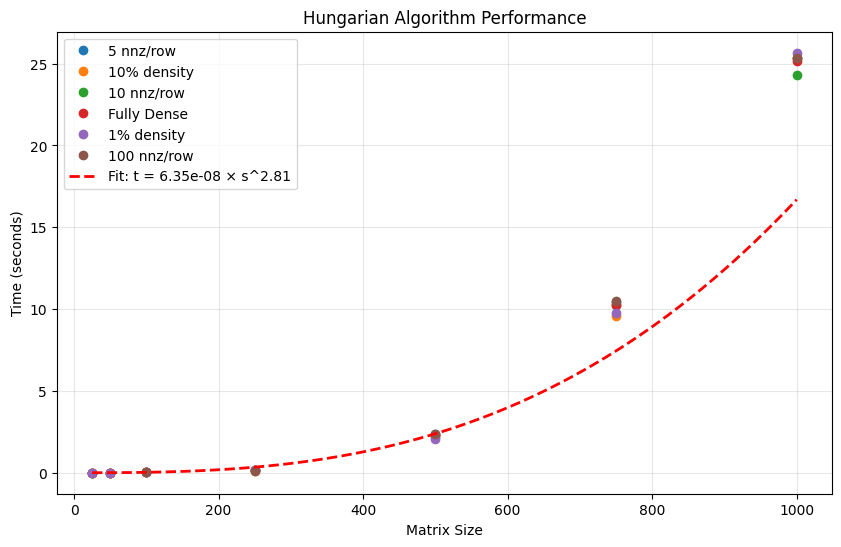

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Group results by scenario
for scenario_name in set(r['scenario'] for r in results):
    # Get data for this scenario
    scenario_results = [r for r in results if r['scenario'] == scenario_name and r['completed']]
    if not scenario_results:
        continue
    
    # Extract sizes and times
    sizes = [r['size'] for r in scenario_results]
    times = [r['time'] for r in scenario_results]
    
    # Sort by size
    sorted_data = sorted(zip(sizes, times))
    sizes, times = zip(*sorted_data)
    
    # Plot
    plt.plot(sizes, times, 'o', label=scenario_name)
## Collect all completed results
all_sizes = []
all_times = []
for r in results:
   if r['completed']:
       all_sizes.append(r['size'])
       all_times.append(r['time'])

# Convert to numpy arrays
sizes = np.array(all_sizes)
times = np.array(all_times)

# Fit power law: t = A * s^b
# Take log: log(t) = log(A) + b*log(s)
log_sizes = np.log(sizes)
log_times = np.log(times)
coeffs = np.polyfit(log_sizes, log_times, 1)
b = coeffs[0]
log_A = coeffs[1]
A = np.exp(log_A)


# Plot power law fit
x_smooth = np.linspace(min(sizes), max(sizes), 100)
y_smooth = A * x_smooth**b
plt.plot(x_smooth, y_smooth, 'r--', linewidth=2, label=f'Fit: t = {A:.2e} × s^{b:.2f}')
plt.xlabel('Matrix Size')
plt.ylabel('Time (seconds)')
plt.title('Hungarian Algorithm Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()